<a href="https://colab.research.google.com/github/william-engel/JetsonNano/blob/main/Jetson_Nano_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jetson Nano Object Detection

In [4]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [5]:
resnet = ResNet50(include_top = True, weights = 'imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [6]:
# https://www.tensorflow.org/hub/tutorials/tf2_object_detection
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [7]:
IMAGES_FOR_TEST = {
  'Husky' : 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630',
  'Bird'  : 'https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg',
  'Monkey': 'https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg',
  'Snake' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Eastern_Indigo_Snake.jpg/1024px-Eastern_Indigo_Snake.jpg'
}

In [8]:
def create_resnet():
  input = tf.keras.Input(shape = (None, None, 3), dtype = tf.uint8) # take varying input
  x = tf.cast(input, dtype = tf.float32) # tensorflow expects float32
  x = preprocess_input(x)
  x = resnet(x)
  model = tf.keras.Model(inputs = [input], outputs = [x])
  return model

In [9]:
model = create_resnet()
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
_________________________________________________________________
None


In [10]:
res = model.predict(load_image_into_numpy_array(IMAGES_FOR_TEST['Bird']))

In [11]:
print(decode_predictions(res))

40960/35363 [==================================] - 0s 0us/step
[[('n01828970', 'bee_eater', 0.11329576), ('n01833805', 'hummingbird', 0.07099919), ('n01537544', 'indigo_bunting', 0.061053086), ('n02219486', 'ant', 0.04413982), ('n02165456', 'ladybug', 0.03859717)]]


In [12]:
INPUT_SHAPE = (224, 224)
def preprocess_images(image_dict):
  image_batch = []

  for key, val in image_dict.items():
    img = load_image_into_numpy_array(val)
    img = tf.image.resize(img, INPUT_SHAPE) / 255.0
    image_batch.append(img[0,...])
  return np.array(image_batch)


In [13]:
image_batch = preprocess_images(IMAGES_FOR_TEST)
print(image_batch.shape)

(4, 224, 224, 3)


In [14]:
prediction_batch = model.predict(image_batch)
print(decode_predictions(prediction_batch))

[[('n06359193', 'web_site', 0.06693499), ('n01930112', 'nematode', 0.049786612), ('n03196217', 'digital_clock', 0.046532083), ('n03729826', 'matchstick', 0.041259874), ('n04404412', 'television', 0.029232306)], [('n06359193', 'web_site', 0.07331444), ('n01930112', 'nematode', 0.056553792), ('n03729826', 'matchstick', 0.044771794), ('n03196217', 'digital_clock', 0.044075105), ('n04286575', 'spotlight', 0.027680919)], [('n06359193', 'web_site', 0.07291041), ('n01930112', 'nematode', 0.05620299), ('n03729826', 'matchstick', 0.044773646), ('n03196217', 'digital_clock', 0.04453247), ('n04286575', 'spotlight', 0.027740484)], [('n06359193', 'web_site', 0.073070325), ('n01930112', 'nematode', 0.056558657), ('n03729826', 'matchstick', 0.044912327), ('n03196217', 'digital_clock', 0.044147026), ('n04286575', 'spotlight', 0.02787291)]]


In [15]:
def plot_images_and_predictions(image_batch, prediction_batch):
  fig = plt.plot(figsize = (10, 10))

  for image, prediction in zip(image_batch, prediction_batch):
    print(image.shape)
    print(prediction)

(224, 224, 3)
[7.16279610e-05 6.91359048e-04 1.18962387e-04 1.15622846e-04
 1.95156637e-04 1.25871025e-04 1.07308006e-04 1.49769476e-04
 7.98965193e-05 3.74573545e-04 2.10745144e-04 1.36515650e-04
 1.04958111e-04 1.17957228e-04 2.31042995e-05 1.93644199e-04
 5.04141608e-05 8.52719313e-05 1.25744438e-04 6.43821040e-05
 2.57885025e-04 2.53019010e-04 3.97490134e-04 1.16326883e-04
 2.68737844e-04 2.80724606e-04 1.18420023e-04 1.26451851e-04
 5.75825747e-04 3.76766460e-04 1.03515027e-04 8.75762722e-04
 1.18340431e-04 3.70640446e-05 6.16928679e-04 1.27918138e-05
 1.01582205e-04 1.60968084e-05 2.66568456e-03 1.25119303e-04
 1.23640566e-04 2.90468506e-05 5.55899642e-05 3.20323270e-05
 1.12663074e-04 8.59368738e-05 1.06175830e-04 1.90664461e-04
 7.73646534e-05 3.61840175e-05 1.76763555e-04 1.60416908e-04
 3.00187996e-04 4.73138352e-04 2.75296858e-04 4.61117947e-04
 3.56853270e-05 1.09825241e-05 5.49259785e-05 5.23006637e-03
 2.12101359e-03 8.47861593e-05 2.02539275e-04 5.92684897e-04
 3.8332355

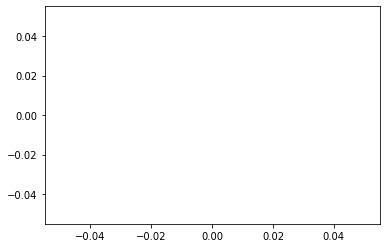

In [16]:
plot_images_and_predictions(image_batch, prediction_batch)

In [17]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

#Inference with native TF2.0 saved model

In [18]:
model = tf.keras.models.load_model('resnet50_saved_model')